<a id="Subcluster_myeloid"></a>
## Sub-cluster monocytes

- [1. Load raw data and clsutering data](#load)
- [2. Script for processing monocytes](#script)
- [3. Iterative subclustering 1 - removes clear doublets and replicating lymphocytes](#cluster_1)
- [4. Iterative subclustering 2 - removes neutrophils](#cluster_2)
- [5. Iterative subclustering 3 - removes RBCs, platelets, plasmablasts, pDCs, some doublets](#cluster_3)
- [6. Iterative subclustering 4 - remove straggler doublets](#cluster_4)
- [7. Iterative subclustering 5 - final clustering consiting only of monocytes and conventional DCs](#cluster_5)

In [1]:
import os
adir = '../../../../data/ExVivo/Seqwell'
project_name = 'exvivo2_20200318_mmul8_V4'
abase = os.path.join(adir, project_name)
gcs = False
abase

'../../../../data/ExVivo/Seqwell/exvivo2_20200318_mmul8_V4'

In [2]:
count_thresh=0
gene_thresh=300
mitothresh=.1
nhvgs = None
logstatus = 'log'

In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [4]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import re

## Functions for reading files straight from google cloud storage
import sys
sys.path.append('../../../Code')
from utils import save_adata, read_adata, subcluster_iteration

import palettable
from IPython.display import display

from joblib import parallel_backend

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80, vector_friendly=False, ipython_format='png')

np.random.seed(14)

/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


scanpy==1.4.4.post1 anndata==0.7.1 umap==0.3.10 numpy==1.18.1 scipy==1.4.1 pandas==1.0.3 scikit-learn==0.22.2.post1 statsmodels==0.11.1 python-igraph==0.8.0 louvain==0.6.1


<a id="load"></a>

## Load raw data and previous clustering results

In [5]:
annot_file = os.path.join(adir, '{project}.count_{count}.gene_{gene}.mito_{mito}.TPT.{log}.Blacklist.HVGs_{nhvgs}.scale.SubclusterM.h5ad'.format(project=project_name, count=count_thresh, gene=gene_thresh, mito=mitothresh, nhvgs=nhvgs, log=logstatus))
print(annot_file)

../../../../data/ExVivo/Seqwell/exvivo2_20200318_mmul8_V4.count_0.gene_300.mito_0.1.TPT.log.Blacklist.HVGs_None.scale.SubclusterM.h5ad


In [6]:
adata_annot = read_adata(annot_file, gcs=gcs)

Only considering the two last: ['.SubclusterM', '.h5ad'].
Only considering the two last: ['.SubclusterM', '.h5ad'].


In [7]:
adata_annot

AnnData object with n_obs × n_vars = 78058 × 16456 
    obs: 'batch', 'array_id', 'run', 'BP', 'treatment_full', 'treatment', 'MOI', 'animal', 'hour', 'condition', 'sample', 'n_counts', 'n_genes', 'log_count', 'PCT_USABLE_BASES', 'PCT_MRNA_BASES', 'EBOV_counts', 'num_EBOV_genes', 'percent_EBOV', 'EBOV_TPT', 'log10_EBOV_TPT', 'percent_mito', 'PCT_UNUSABLE_BASES', 'percent_hbb', 'leiden', 'leiden_lab', 'leiden_lab_group', 'Subclustering', 'SubclusteringGroup', 'Doublet'
    var: 'full_id', 'gene_symbol', 'gene_id', 'human_ortholog_id', 'human_ortholog_name', 'human_ortholog_type', 'human_ortholog_percent_identity', 'human_ortholog_percent_confidence', 'merged_symbol', 'n_cells', 'Combined_Blacklist', 'CC_Blacklist', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'condition_colors', 'leiden', 'leiden_colors', 'leiden_lab_colors', 'leiden_lab_group_colors', 'neighbors', 'pca', 'rank_genes_groups', 'sample_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

In [8]:
adata_raw = sc.AnnData(adata_annot.raw.X, obs=adata_annot.obs, var=adata_annot.raw.var, uns=adata_annot.uns)
adata_raw = adata_raw[adata_raw.obs['leiden_lab_group'].isin(['B', 'Plasmablast']), :]

adata_raw_full = adata_raw.copy()

adata_raw = adata_raw[:,~(adata_raw.var['Combined_Blacklist'] | adata_raw.var['CC_Blacklist'])]
sc.pp.filter_genes(adata_raw, min_cells=10)

sc.pp.normalize_per_cell(adata_raw, counts_per_cell_after=10000)
sc.pp.log1p(adata_raw)

sc.pp.normalize_per_cell(adata_raw_full, counts_per_cell_after=10000)
sc.pp.log1p(adata_raw_full)

adata_raw.raw = adata_raw_full

filtered out 3231 genes that are detectedin less than 10 cells


Trying to set attribute `.var` of view, copying.


normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


<a id="cluster_1"></a>
## Iterative subclustering 1 - removes doublets

In [9]:
genestoplot = ['MS4A1', 'CD3D', 'IGHM', 'ENSMMUG00000002764', 'ENSMMUG00000015202', 'MZB1', 'MKI67', 'HBB', 'MAMU-DPB']

In [10]:
(adata_raw.shape[0]*.001)

17.134

extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:869: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


computing PCA with n_comps = 50
computing PCA on highly variable genes
    finished (0:00:05)


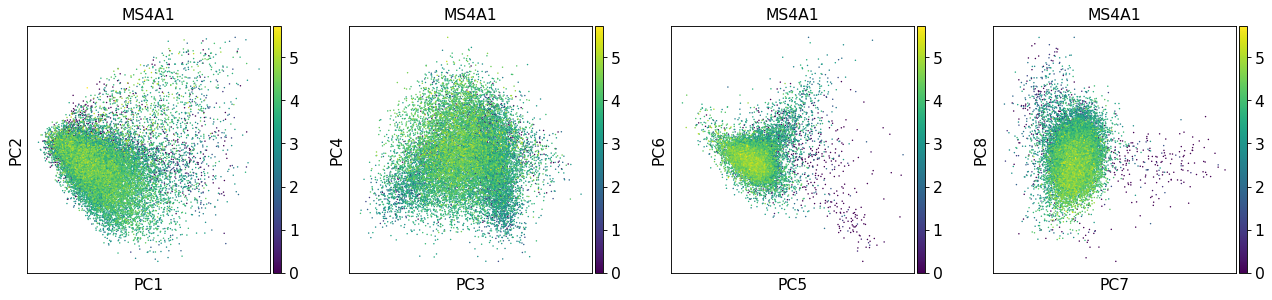

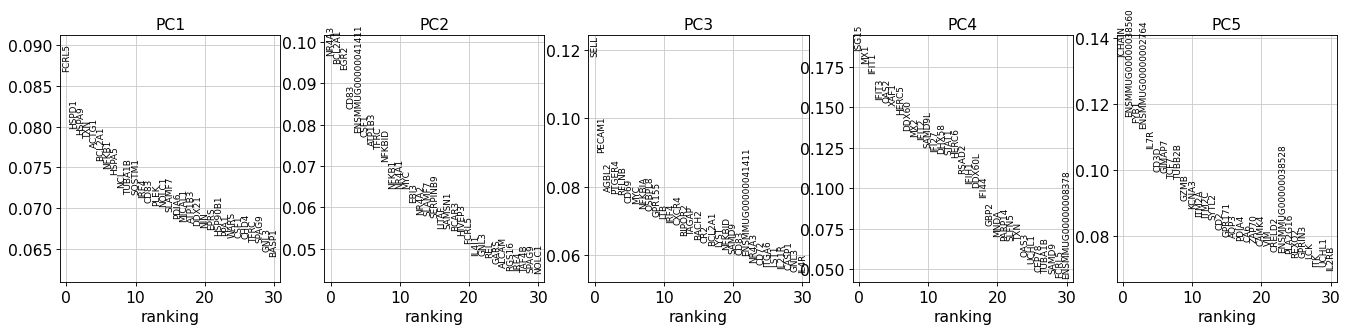

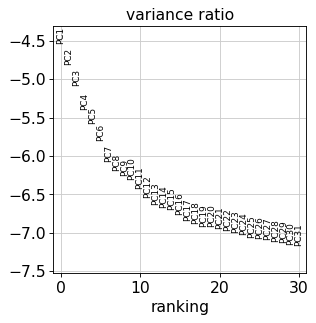

computing neighbors
    using 'X_pca' with n_pcs = 17


/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../../../../../opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  state.func_ir.loc))
/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../..

    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:14)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:27)
running Leiden clustering
    finished: found 13 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:14)


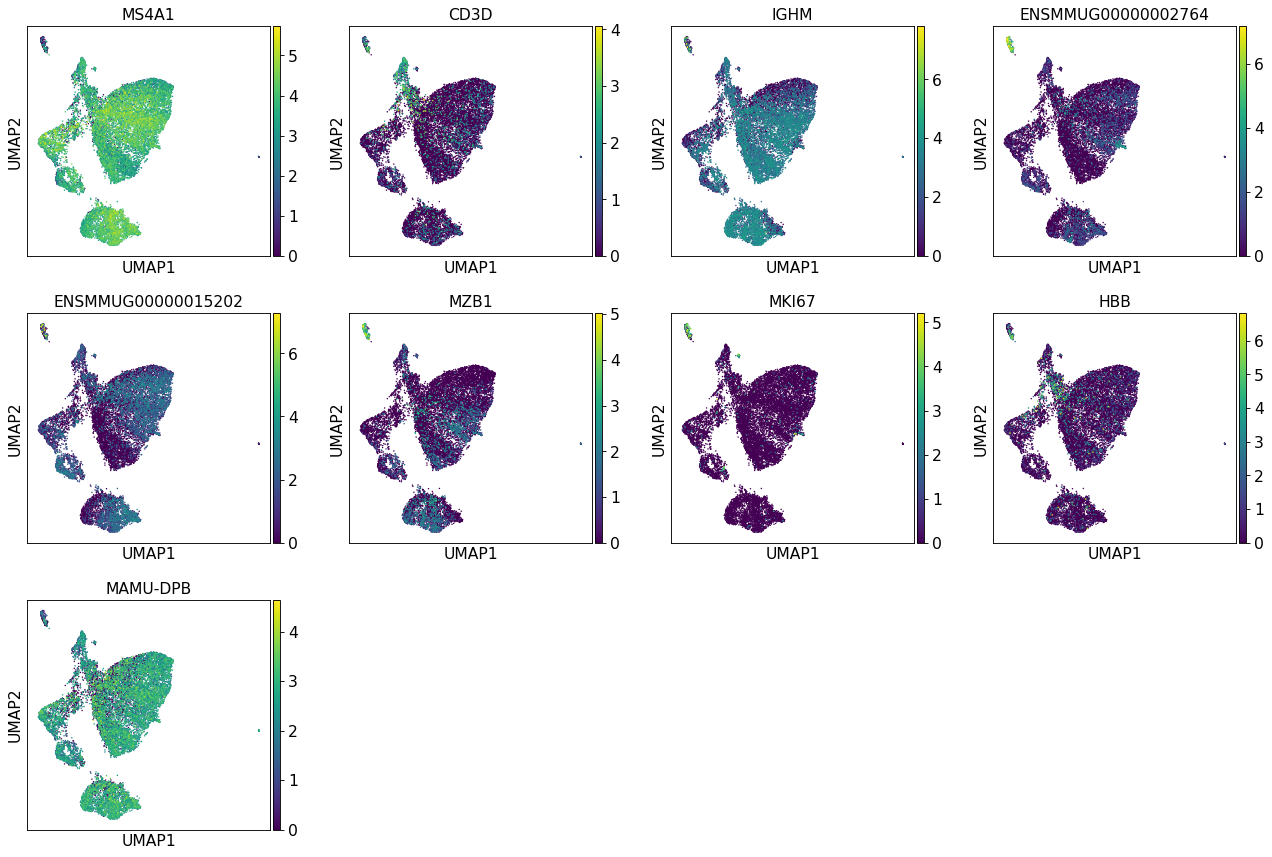

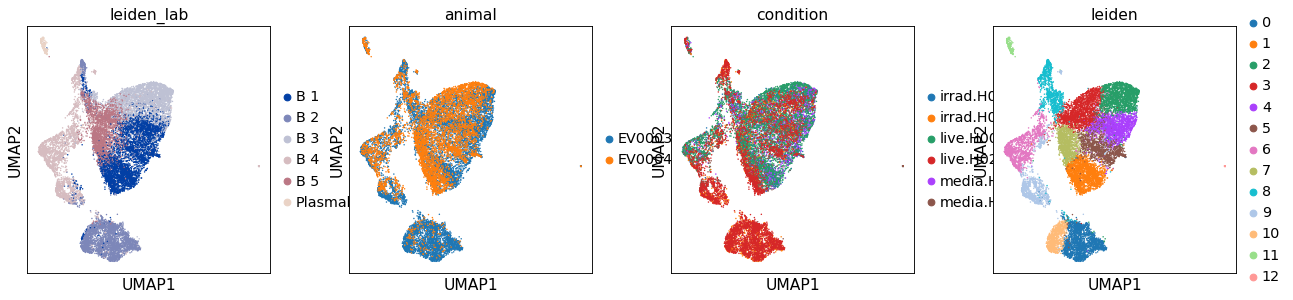

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:28)


0        1                   2                   3  \
0                  MX2     SELL             S100A10  ENSMMUG00000014256   
1                  MX1     CTSH               SYNE1             S100A10   
2                IFIT1   PECAM1              LAPTM5               RPL35   
3               RNF213   OSBPL8                 VIM               RPL17   
4                ISG15   RPS27A               ITGB2               RPS11   
5                HERC5   RIPOR2                TESC  ENSMMUG00000048425   
6               SAMD9L    RFLNB               ANXA2               RPL30   
7                 XAF1      LTB  ENSMMUG00000014256                 VIM   
8                 OAS2    CXCR4                 FGR  ENSMMUG00000012140   
9                IFIT3     LYST             RASGRP1  ENSMMUG00000003867   
10               DDX60    CD79B               PEBP1                RPS6   
11               HERC6  PLEKHA2               LUZP1               MS4A1   
12              DDX60L    RPL18                LCP1              RPL13A   
13               DHX58   GPR155               IFI30              LAPTM5   
14               IFI16    RACK1              PTPN22               RPL27   
15               STAT1     ETS1               ADAM8               RPL11   
16                IFI6     TPT1  ENSMMUG00000017838              GPR183   
17               IFIT2     IGHM               ANXA4              RPL27A   
18  ENSMMUG00000013257  CSNK1G3            ARHGAP27               RPS23   
19               ISG20    AGBL2               CNDP2                CD19   

                     4                   5         6                   7  \
0             KIAA0040                AIM2      CD83              RPS27A   
1                IFI30                TCF4  HSP90AB1              RPL13A   
2                 CD1C               CD79B    BCL2A1                TPT1   
3                CD79A                CD52     NFKB1               RPS23   
4                 CYBB              RIPOR2    ATP1B3               RPL17   
5                 GDI2           C10orf128       NCL  ENSMMUG00000015270   
6                 FGD2               SYNE2      IRF4  ENSMMUG00000003867   
7                 CD19             FAM214A     FCRL5               RPS11   
8                 CD72  ENSMMUG00000014256       NIN               RPL30   
9                  LYZ                ACP5    NFKBID                RPS6   
10               ITGB2                ADD3       RAN               RPS20   
11  ENSMMUG00000012140               LPAR6     HSPA9               RPL23   
12               CD79B             RNASET2     NOLC1  ENSMMUG00000002676   
13              PMEPA1             RPL22L1     DDX21               RPL11   
14             FAM107B               ITGA4      GNL3               RPL35   
15               PADI2               MS4A1     HSPA8                RPS5   
16             RNASET2              JMJD1C       REL                RPS7   
17               FCRLA               COTL1      CHD4               RACK1   
18                DGKD  ENSMMUG00000003867      EGR2                RPL9   
19               MS4A1                ETS1      SFPQ  ENSMMUG00000003073   

         8                   9                  10                  11  \
0   GIMAP7            HSP90AB1                SELL  ENSMMUG00000002764   
1     IL7R               ACTG1                 MX1             HSP90B1   
2     CD3D              TUBA1B                 MX2              JCHAIN   
3     FYB1                 TXN               HERC5  ENSMMUG00000038560   
4      CD2  ENSMMUG00000015781                XAF1               PDIA4   
5     TCF7                RPS2               IFIT1                MZB1   
6      LCK              MICAL1               DHX58               HSPA5   
7   GIMAP8  ENSMMUG00000023144              SAMD9L                SUB1   
8    SORL1              ABRACL              OSBPL8               PDIA6   
9     TPT1                ACTB              RNF213               REXO2   
10    GZMB             RPL22L1  EN

In [11]:
adata_1 = subcluster_iteration(adata_raw, min_cells=10, nhvgs=nhvgs, npcs=17,
                        n_neighbors=30,
                        min_dist=0.1, spread=2.0,resolution=1.,
                        umap_genestoplot=genestoplot, pc_genestoplot=['MS4A1'],
                        other_plot=['leiden_lab', 'animal', 'condition', 'leiden'], harmony=False,
                        scale=True)

In [12]:
adata_1.obs['leiden'].value_counts()

0     2178
1     2031
2     1859
3     1837
4     1771
5     1403
6     1353
7     1224
8     1158
9     1117
10     915
11     259
12      29
Name: leiden, dtype: int64

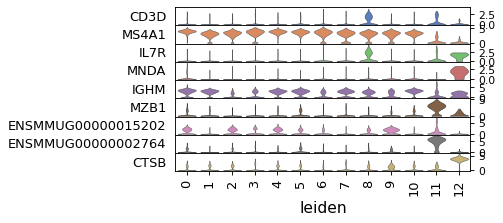

In [13]:
sc.pl.stacked_violin(adata_1, var_names=['CD3D', 'MS4A1', 'IL7R', 'MNDA', 'IGHM', 'MZB1', 'ENSMMUG00000015202', 'ENSMMUG00000002764', 'CTSB'], groupby='leiden', swap_axes=True)

In [14]:
adata_annot.obs.loc[:, 'Doublet'] = adata_annot.obs.loc[:, 'Doublet'].astype(str)
doublet_ind = adata_1.obs.index[adata_1.obs['leiden'].isin(['8', '12'])]
adata_annot.obs.loc[doublet_ind, 'Doublet'] = True

adata_annot.obs.loc[:, 'Subclustering'] = adata_annot.obs.loc[:, 'Subclustering'].astype(str)
adata_annot.obs.loc[:, 'SubclusteringGroup'] = adata_annot.obs.loc[:, 'SubclusteringGroup'].astype(str)

plasmablast_ind = adata_1.obs.index[adata_1.obs['leiden'].isin(['11'])]
adata_annot.obs.loc[plasmablast_ind, 'Subclustering'] = 'Plasmablast 1'
adata_annot.obs.loc[plasmablast_ind, 'SubclusteringGroup'] = 'Plasmablast'

<a id="cluster_2"></a>
## Iterative subclustering 2 - removes neutrophils

In [15]:
genestoplot2 = ['MS4A1', 'SELL', 'ITGB2', 'IGKC', 'CD79B', 'frz_status', 'MAMU-DPB']

filtered out 328 genes that are detectedin less than 10 cells
extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:869: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


computing PCA with n_comps = 50
computing PCA on highly variable genes
    finished (0:00:04)


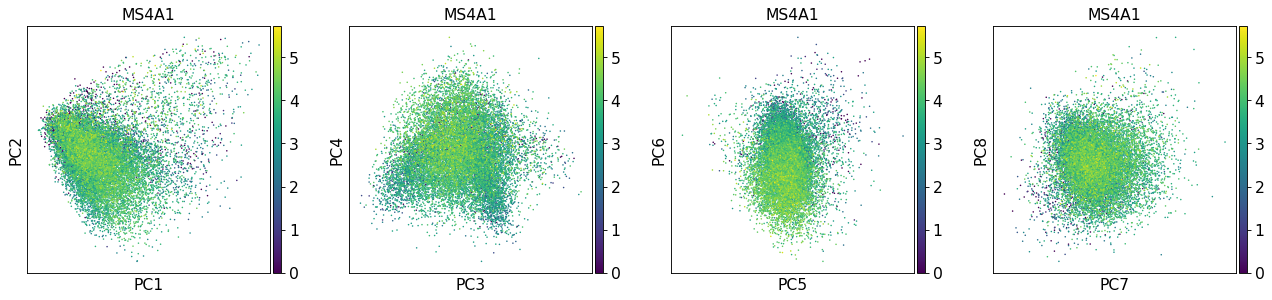

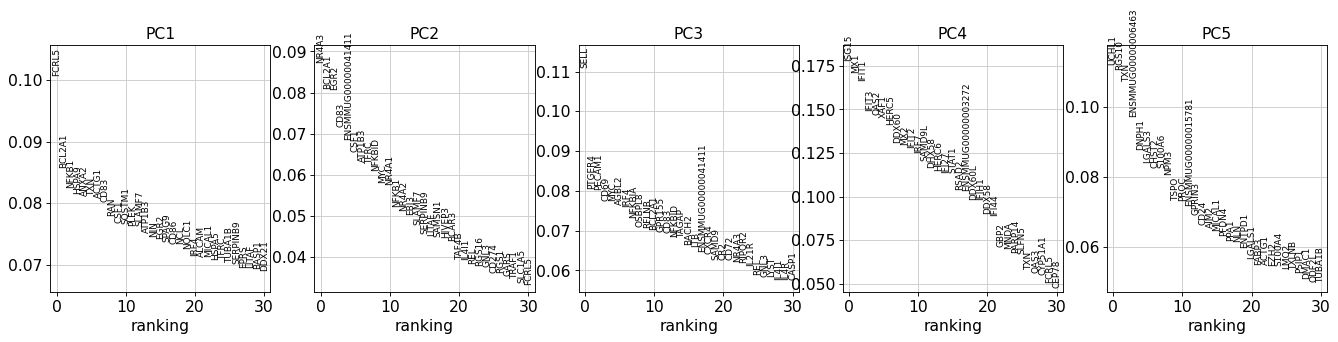

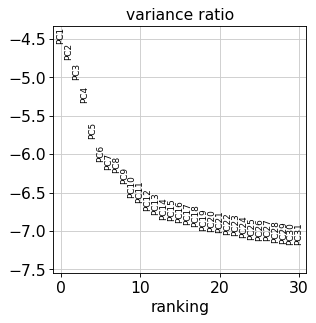

computing neighbors
    using 'X_pca' with n_pcs = 14


/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../../../../../opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:08)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:24)
running Leiden clustering
    finished: found 18 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:13)


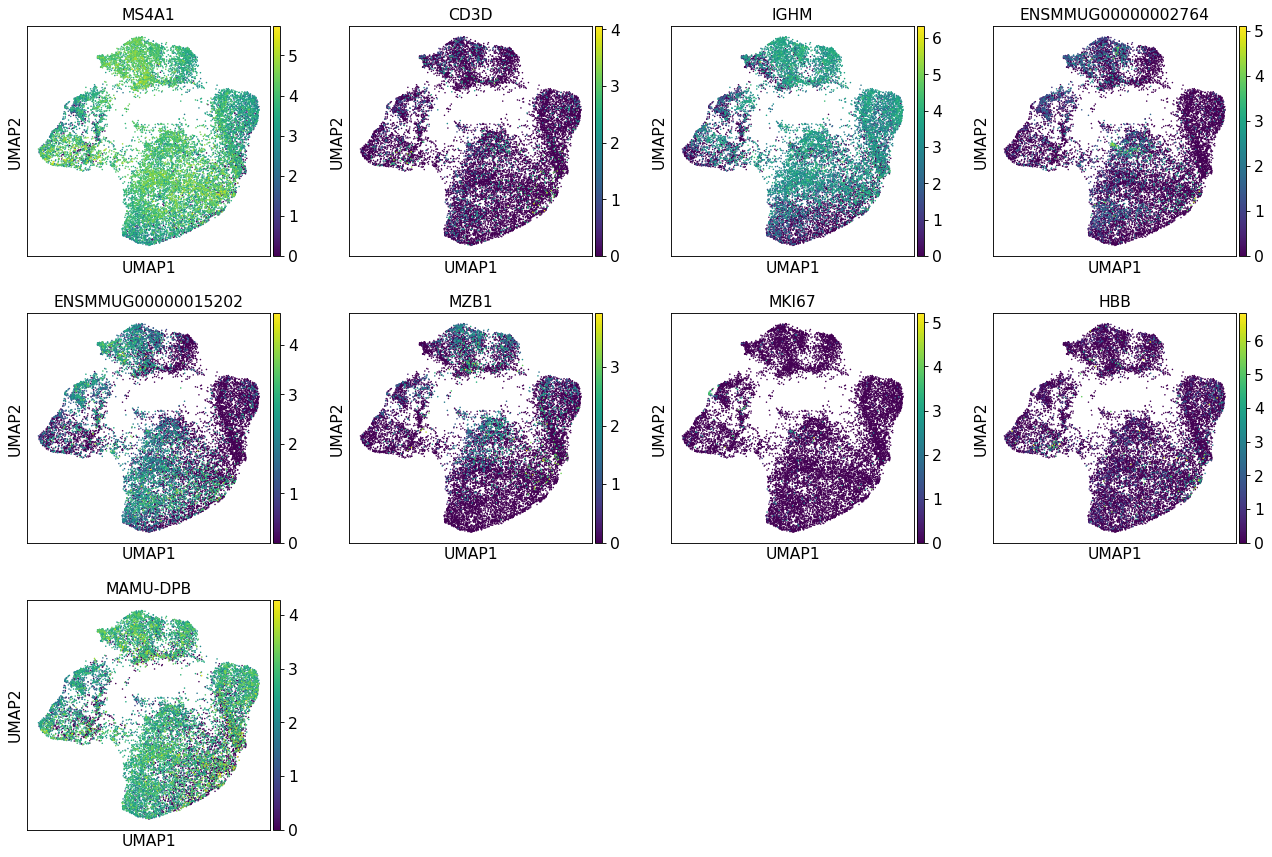

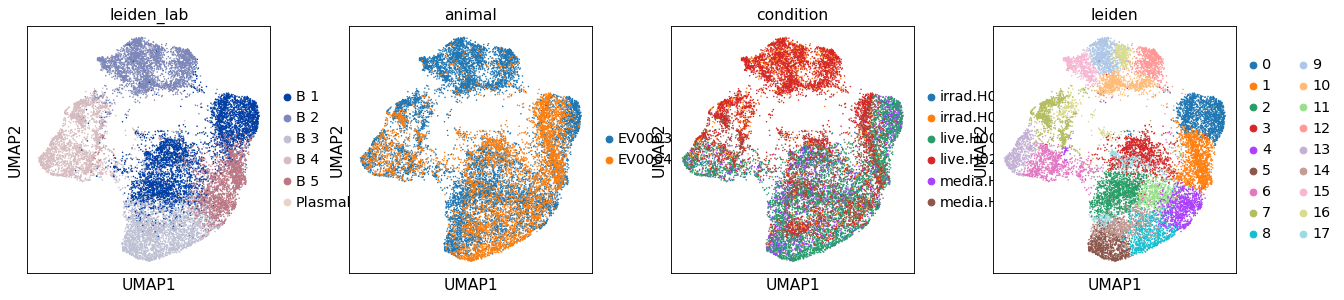

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:28)


0                   1                   2          3  \
0      SELL              RPS27A               CD79A       TCF4   
1    PECAM1                TPT1               IFI30      CD79B   
2      CTSH              RPL13A            KIAA0040       AIM2   
3    OSBPL8               RPS23                CD1C       IGHM   
4    RIPOR2               RPL17                GDI2       CD52   
5     RFLNB  ENSMMUG00000015270                CYBB    FAM214A   
6     CXCR4  ENSMMUG00000003867               ITGB2     RIPOR2   
7       LTB               RPS11              PMEPA1      LPAR6   
8      LYST               RPL30               PREX1  C10orf128   
9    RPS27A               RPS20                FGD2       ETS1   
10    CD79B                RPS6                 LYZ       CD24   
11     ETS1               RPL11                DGKD      SYNE2   
12    RPL18               RPL23               SEPT9       ACP5   
13   GPR155                RPS7  ENSMMUG00000012140       CHD9   
14  PLEKHA2  ENSMMUG00000002676                CD19     CYFIP2   
15     IGHM                RPS5              GRAMD4      COTL1   
16    CD79A               RACK1              PLXNB2      CASP1   
17    AGBL2               RPL35              ATP2A3    SPATS2L   
18     UTRN               RPS14                CD72       MZB1   
19    RACK1  ENSMMUG00000003073             FAM107B     PECAM1   

                     4                   5                   6  \
0   ENSMMUG00000014256              LAPTM5                CD83   
1                RPL30             S100A10            HSP90AB1   
2                RPL35                 VIM               FCRL5   
3                RPL17               ITGB2              ATP1B3   
4                 RPS6               SYNE1  ENSMMUG00000041411   
5                RPS11                 FGR              BCL2A1   
6   ENSMMUG00000003867               ANXA2                IRF4   
7               RPL13A                TESC               NFKB1   
8                MS4A1               ADAM8                 NIN   
9                RPS23               IFI30             ZFP36L1   
10              RPL27A  ENSMMUG00000017838              NFKBID   
11               RPL11                ACTB               BASP1   
12               RPS20               FMNL1                 NCL   
13  ENSMMUG00000015270              SYNGR2               LITAF   
14               RPL27            ARHGAP27               FCRL3   
15               RPS14               PEBP1                EGR2   
16              RPL23A               LUZP1                LCP1   
17                RPS7               CD79A              SAMSN1   
18               RPLP2               PREX1                 RAN   
19                RPL6                LCP1               HSPA8   

                     7                   8                   9  \
0                ACTG1             S100A10                 MX2   
1             HSP90AB1  ENSMMUG00000014256                 MX1   
2                  TXN                 VIM               IFIT1   
3               TUBA1B              GPR183              RNF213   
4   ENSMMUG00000015781  ENSMMUG00000012140              SAMD9L   
5                ANXA2  ENSMMUG00000048425               HERC5   
6               ABRACL                TESC               ISG15   
7               MICAL1               SYNE1               IFIT3   
8               LGALS1              MYL12A                OAS2   
9   ENSMMUG00000023144              LAPTM5                XAF1   
10                RPS2               PEBP1               IFIT2   
11                LCP1               ACTG1               DDX60   
12                TSPO                RHOA              DDX60L   
13              LGALS3             FAM107B               HERC6   
14                RPSA                CREM               IFI16   
15               CHST2                LCP1               DHX58   
16               GAPDH               ACTR2  ENSMMUG00000013257   
17                 DBI               YWHAB      

In [16]:
keep = adata_1.obs.index[~adata_1.obs['leiden'].isin(['8', '11', '12'])]
adata_2 = subcluster_iteration(adata_raw[keep,:], min_cells=10, nhvgs=nhvgs, npcs=14,
                        n_neighbors=30,
                        min_dist=0.1, spread=2.0,resolution=1.5,
                        umap_genestoplot=genestoplot, pc_genestoplot=['MS4A1'],
                        other_plot=['leiden_lab', 'animal', 'condition', 'leiden'], harmony=False,
                        scale=True)

In [17]:
adata_2.obs['leiden'].value_counts()

0     1635
1     1416
2     1363
3     1055
4      994
5      944
6      902
7      895
8      798
9      788
10     766
11     686
12     673
13     641
14     591
15     565
16     520
17     456
Name: leiden, dtype: int64

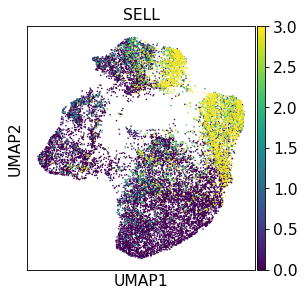

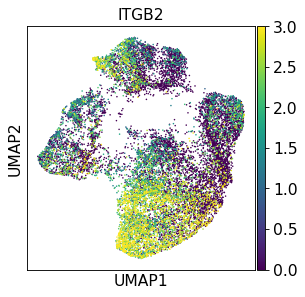

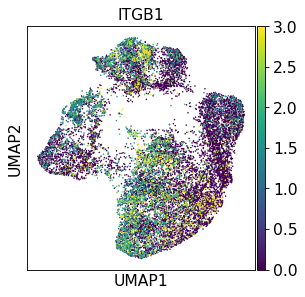

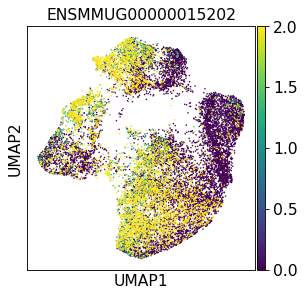

In [18]:
sc.pl.umap(adata_2, color=['SELL'], vmax=3)
sc.pl.umap(adata_2, color=['ITGB2'], vmax=3)
sc.pl.umap(adata_2, color=['ITGB1'], vmax=3)
sc.pl.umap(adata_2, color=['ENSMMUG00000015202'], vmax=2)

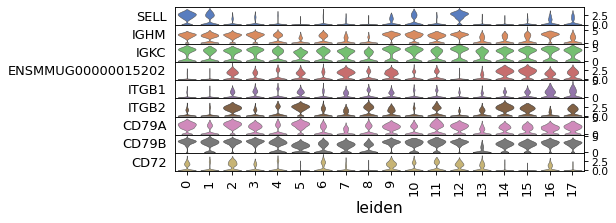

In [19]:
_ = sc.pl.stacked_violin(adata_2, var_names=['SELL',  'IGHM', 'IGKC', 'ENSMMUG00000015202',  'ITGB1', 'ITGB2', 'CD79A', 'CD79B', 'CD72'], groupby='leiden', swap_axes=True)

In [20]:
## Harmony + baseline PCs
labmap = {}
naive_count = 1
memory_count = 1
for i in range(18):
    if i not in [0, 1, 12]:
        labmap[str(i)] = 'B_Memory ' + str(memory_count)
        memory_count += 1
    else:
        labmap[str(i)] = 'B_Naive ' + str(naive_count)
        naive_count += 1
        
labmap

{'0': 'B_Naive 1',
 '1': 'B_Naive 2',
 '2': 'B_Memory 1',
 '3': 'B_Memory 2',
 '4': 'B_Memory 3',
 '5': 'B_Memory 4',
 '6': 'B_Memory 5',
 '7': 'B_Memory 6',
 '8': 'B_Memory 7',
 '9': 'B_Memory 8',
 '10': 'B_Memory 9',
 '11': 'B_Memory 10',
 '12': 'B_Naive 3',
 '13': 'B_Memory 11',
 '14': 'B_Memory 12',
 '15': 'B_Memory 13',
 '16': 'B_Memory 14',
 '17': 'B_Memory 15'}

In [21]:
adata_2.obs['leiden_lab'] = adata_2.obs['leiden'].replace(labmap)
adata_2.obs['leiden_lab_group'] = adata_2.obs['leiden_lab'].apply(lambda x: x.split(' ')[0])

... storing 'leiden_lab' as categorical
... storing 'leiden_lab_group' as categorical


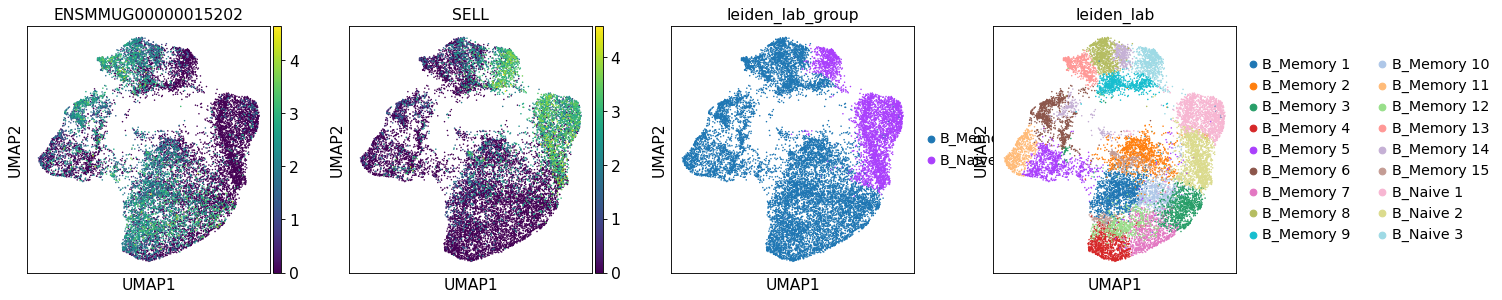

In [22]:
sc.pl.umap(adata_2, color=['ENSMMUG00000015202','SELL','leiden_lab_group', 'leiden_lab'])

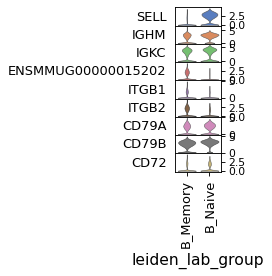

In [23]:
_ = sc.pl.stacked_violin(adata_2, var_names=['SELL',  'IGHM', 'IGKC', 'ENSMMUG00000015202',  'ITGB1', 'ITGB2', 'CD79A', 'CD79B', 'CD72'], groupby='leiden_lab_group', swap_axes=True)

In [24]:
adata_annot.obs['Subclustering'] = adata_annot.obs['Subclustering'].astype(str)
adata_annot.obs['SubclusteringGroup'] = adata_annot.obs['SubclusteringGroup'].astype(str)
adata_annot.obs.loc[adata_2.obs.index, 'SubclusteringGroup'] = adata_2.obs['leiden_lab_group']
adata_annot.obs.loc[adata_2.obs.index, 'Subclustering'] = adata_2.obs['leiden_lab']

In [25]:
results_file = os.path.join(adir, '{project}.count_{count}.gene_{gene}.mito_{mito}.TPT.{log}.Blacklist.HVGs_{nhvgs}.scale.SubclusterMB.h5ad'.format(project=project_name, count=count_thresh, gene=gene_thresh, mito=mitothresh, nhvgs=nhvgs, log=logstatus))
print(results_file)

../../../../data/ExVivo/Seqwell/exvivo2_20200318_mmul8_V4.count_0.gene_300.mito_0.1.TPT.log.Blacklist.HVGs_None.scale.SubclusterMB.h5ad


In [26]:
save_adata(adata_annot, results_file, gcs=gcs)

Only considering the two last: ['.SubclusterMB', '.h5ad'].
Only considering the two last: ['.SubclusterMB', '.h5ad'].


... storing 'Subclustering' as categorical
... storing 'SubclusteringGroup' as categorical
... storing 'Doublet' as categorical


In [27]:
results_file_sub = os.path.join(adir, '{project}.count_{count}.gene_{gene}.mito_{mito}.TPT.{log}.NoMDCK.NoBOD.Blacklist.HVGs_{nhvgs}.scale.OnlyB.h5ad'.format(project=project_name, count=count_thresh, gene=gene_thresh, mito=mitothresh, nhvgs=nhvgs, log=logstatus))
print(results_file_sub)

../../../../data/ExVivo/Seqwell/exvivo2_20200318_mmul8_V4.count_0.gene_300.mito_0.1.TPT.log.NoMDCK.NoBOD.Blacklist.HVGs_None.scale.OnlyB.h5ad


In [28]:
save_adata(adata_2, results_file_sub, gcs=gcs)

Only considering the two last: ['.OnlyB', '.h5ad'].
Only considering the two last: ['.OnlyB', '.h5ad'].


In [29]:
pd.crosstab([adata_annot.obs['leiden_lab'], adata_annot.obs['Doublet']], adata_annot.obs['SubclusteringGroup'])

SubclusteringGroup   B_Memory  B_Naive  Mono  Plasmablast  cDC   nan
leiden_lab  Doublet                                                 
B 1         False        2790     2004     0            2    0     0
            True            0        0     0            0    0   150
B 2         False        2540      658     0            0    0     0
            True            0        0     0            0    0   259
B 3         False        3140        1     0            0    0     0
            True            0        0     0            0    0   143
B 4         False        2380       11     0            4    0     0
            True            0        0     0            0    0   348
B 5         False        1102     1050     0            1    0     0
            True            0        0     0            0    0   284
Mono/DC 1   False           0        0  1491            0   10     0
            True            0        0     0            0    0   388
Mono/DC 2   False           0        0  1113            0    1     0
            True            0        0     0            0    0   266
Mono/DC 3   False           0        0     2            0  395     0
            True            0        0     0            0    0   356
Multiplet 1 False           0        0     0            0    0  8244
Multiplet 2 False           0        0     0            0    0  6782
Multiplet 3 False           0        0     0            0    0  5602
Multiplet 4 False           0        0     0            0    0  3920
Multiplet 5 False           0        0     0            0    0  1102
NK 1        False           0        0     0            0    0  7773
NK 2        False           0        0     0            0    0   360
Plasmablast False          12        0     0          252    0     0
            True            0        0     0            0    0     3
Tc 1        False           0        0     0            0    0  5694
Th 1        False           0        0     0            0    0  8303
Th 3        False           0        0     0            0    0  4510
Th 4        False           0        0     0            0    0  3138
Th 5        False           0        0     0            0    0  1474